# Introduction

The main purpose of this repository is to show how machine learning can be used to *understand what is happening and why*, rather than just for prediction. However, the data setup is often the same for both, so I may as well do both.

Here, I will attempt to predict a company's value (market cap). To do so, I use Optuna to tune an xgboost regressor. I then train the winning model and do a bit of performance analysis, finishing with a quick list of "todos".

In the next notebook I'll demonstrate how to use ML to teach us from the data instead.

---

Disclaimer: I am not an investment professional. None of my work within or related to this notebook should be considered investment advice. It is not.

In [1]:
import duckdb
import os
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from datetime import datetime

data_path = Path(os.getenv('DATA_HOME'))
duckdb_path = data_path.joinpath('analytics_demo/sharadar.duckdb')

# Setup

In [2]:
con = duckdb.connect(str(duckdb_path))
df_fct_daily_targ = con.execute('from fct_daily_targ where mcap_daily > 0').fetch_df()
df_mcap_reg = con.execute('from mcap_reg').fetch_df()
con.close()

print('fct_daily_targ:', df_fct_daily_targ.shape)
display(df_fct_daily_targ.head(2))
print('df_mcap_reg:', df_mcap_reg.shape)
display(df_mcap_reg.head(2))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

fct_daily_targ: (1764497, 14)


,key_daily,ticker,date,volume,closeadj,mcap_daily,ev_daily,price_chg_1y,excess_price_chg_1y,key_dim_fin,mcap_rank,mcap_perc_rank,mcap_rank_rev,mcap_perc_rank_rev
0,TRTN_2017-07-06,TRTN,2017-07-06,290500.000,24.000,2467400000.000,8759100000.000,0.058,-0.043,TRTN_ART_2017-03-31_2017-05-15,1510,0.292,3664,0.708
1,UST1_1999-01-06,UST1,1999-01-06,404200.000,19.720,6392400000.000,6371300000.000,-0.131,-0.181,UST1_ART_1998-09-30_1998-11-10,357,0.050,6767,0.950


df_mcap_reg: (1131433, 877)


,key_daily,date,mcap_daily_scaled_log,accoci_art_scaled,assets_art_scaled,assetsavg_art_scaled,assetsc_art_scaled,assetsnc_art_scaled,capex_art_scaled,cashneq_art_scaled,...,liabilitiesc_over_fcf_art_chg,payables_over_assetsavg_art_chg,payables_over_revenue_art_chg,payables_over_fcf_art_chg,ncfx_over_assetsavg_art_chg,ncfx_over_revenue_art_chg,ncfx_over_fcf_art_chg,deferredrev_over_assetsavg_art_chg,deferredrev_over_revenue_art_chg,deferredrev_over_fcf_art_chg
0,CLGRF_2015-03-04,2015-03-04,9.203,0.209,0.000,0.000,0.000,0.000,0.999,0.000,...,-1.545,0.007,0.016,-0.084,0.000,0.000,-0.000,-0.009,-0.039,0.148
1,WKSP_2020-11-04,2020-11-04,5.968,0.082,0.000,0.000,0.000,0.000,1.000,0.000,...,1.158,0.597,0.357,0.399,0.031,0.030,-0.073,0.000,0.000,-0.000


# EDA &  Prep

I'm going to use an expanding window for tuning, training through a given year then predicting a few following years' worth of market cap values.

![Time Series ML Folds](./images/time_series_ml_folds.png)

Tasks:
- Impute +/- inf.
- Drop features with too many nulls.
- Find a "starting year" for the first training window ("TW1").
- To speed up tuning, use TW1 to build a correlation matrix and drop highly-correlated features.

In [4]:
# I'll be using XGBoost, which can handle nulls. Since this is a demo, I'll simply set inf to null.
df_mcap_reg = df_mcap_reg.replace([-np.inf, np.inf], np.nan)

<Axes: >

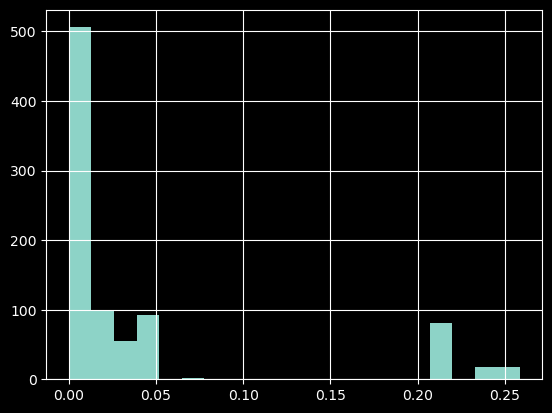

In [5]:
cols_feat = df_mcap_reg.columns.drop(['key_daily', 'date', 'mcap_daily_scaled_log']).tolist()

df_frac_nullity = df_mcap_reg[cols_feat].isnull().mean()
df_frac_nullity.hist(bins=20)

In [6]:
# Arbitrary, but hey.
frac_too_many_nulls = .4

cols_feat_drop_for_nullity = set(df_frac_nullity[df_frac_nullity > frac_too_many_nulls].index)
print("{} feature columns dropped for having too many nulls.".format(str(len(cols_feat_drop_for_nullity))))
cols_feat = list(set(cols_feat).difference(cols_feat_drop_for_nullity))

0 feature columns dropped for having too many nulls.


<Axes: xlabel='date'>

date
1998       56
1999      880
2000     1077
2001    13858
2002    39286
2003    51210
2004    53351
2005    53748
2006    52823
2007    52057
2008    51048
Name: count, dtype: int64

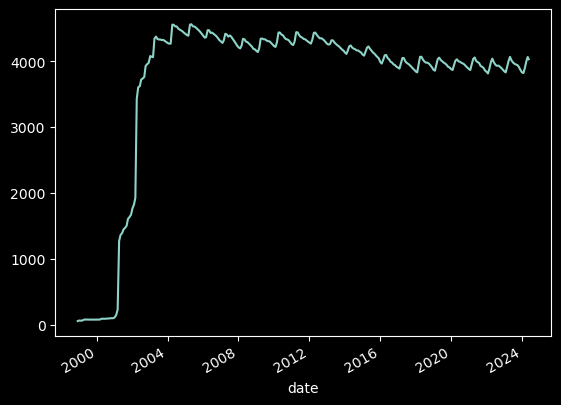

In [7]:
# Compute daily and yearly row counts
display(df_mcap_reg.date.value_counts().sort_index().plot())
display(df_mcap_reg.date.dt.year.value_counts().sort_index().head(11))

Let's extend TW1 through 2007, which will give it 5 full years. Below I create train/predict folds in a way that gives prediction coverage from 2008 to the present year without the need to train one model for each year.

In [8]:
# Store training window partition
first_window_final_year = 2007
years_btw_windows = 5

current_year = datetime.utcnow().year
train_window_limits = list(np.arange(first_window_final_year, current_year, years_btw_windows))
pred_window_lists = [list(range(x + 1, x + years_btw_windows + 1)) for x in train_window_limits]

for ty, py in zip(train_window_limits, pred_window_lists):
    print('[..., {}]'.format(ty), '-->', py)

[..., 2007] --> [2008, 2009, 2010, 2011, 2012]
[..., 2012] --> [2013, 2014, 2015, 2016, 2017]
[..., 2017] --> [2018, 2019, 2020, 2021, 2022]
[..., 2022] --> [2023, 2024, 2025, 2026, 2027]


In [9]:
#### For variable pairs with this absolute correlation or greater, keep only one.
max_corr = 0.95

# Sample within the first train window then compute correlation matrix.
tw1_limit = min(train_window_limits)
X_corr = df_mcap_reg.loc[df_mcap_reg.date.dt.year <= tw1_limit, cols_feat].sample(n=10000).corr()

# Convert to upper triangle then find list of columns with strong correlation.
X_corr = X_corr.where(np.triu(np.ones(X_corr.shape), k=1).astype(bool))
correlated_feat_drop = [c for c in X_corr.columns if any(X_corr[c].abs() > max_corr)]
print("Will drop {} of {} features.".format(str(len(correlated_feat_drop)), str(len(cols_feat))))

cols_feat_keep_low_corr = list(set(X_corr.columns).difference(set(correlated_feat_drop)))

Will drop 432 of 874 features.


In [15]:
import cudf
import cupy
from itertools import product
import optuna
from sklearn.metrics import mean_absolute_percentage_error as mape_score
import xgboost

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import joblib
import os
from pathlib import Path
study_filepath = data_path.joinpath("analytics_demo").joinpath('supervised_ml_study.pkl')
best_model_filepath = data_path.joinpath("analytics_demo").joinpath('reg_xgb_best.pkl')

# Tune ML

For hyperparameter tuning, rather than using just a grid *or* an optimizer, I like to force a basic grid search *then* run an optimizer. Otherwise they seem prone to getting stuck at local optima. Optuna's `enqueue_trial()` allows for just this.

In [11]:
cudf_reg = cudf.from_pandas(df_mcap_reg[['key_daily', 'date', 'mcap_daily_scaled_log'] + cols_feat_keep_low_corr])
cudf_reg.shape

(1131433, 445)

In [12]:
# Create boolean masks, which I call selectors, for train and prediction windows.
train_window_selectors = [cudf_reg.date.dt.year <= cutoff_yr for cutoff_yr in train_window_limits]
prediction_window_selectors = [cudf_reg.date.dt.year.isin(pwl) for pwl in pred_window_lists]
window_selectors = list(zip(train_window_selectors, prediction_window_selectors))

In [12]:
param_labels = ['n_estimators', 'learning_rate', 'max_depth', 'colsample_bytree', 'subsample', 'min_child_weight']

grid_n_estimators = [25, 250]
grid_learning_rate = [0.001, 0.01]
grid_max_depth = [3, 10]
grid_colsample_bytree = [0.1, 0.5]
grid_subsample = grid_colsample_bytree
grid_min_child_weight = [50, 500, 5000]

grid = product(grid_n_estimators, grid_learning_rate, grid_max_depth, grid_colsample_bytree, grid_subsample, grid_min_child_weight)
grid = [{param_labels[i]: g[i] for i in range(len(param_labels))} for g in grid]
print(len(grid), 'models in grid.')
pd.DataFrame(grid).head()

96 models in grid.


,n_estimators,learning_rate,max_depth,colsample_bytree,subsample,min_child_weight
0,25,0.001,3,0.100,0.100,50
1,25,0.001,3,0.100,0.100,500
2,25,0.001,3,0.100,0.100,5000
3,25,0.001,3,0.100,0.500,50
4,25,0.001,3,0.100,0.500,500


In [13]:
study = optuna.create_study(direction='minimize')

[I 2024-05-21 02:59:44,477] A new study created in memory with name: no-name-5911cc79-93b1-40bf-bbfb-d707330cbbce


In [14]:
for _t in grid:
    study.enqueue_trial(_t)

In [15]:
def run_trial(trial):
    global cudf_reg
    cudf_reg['pred'] = cupy.nan
    
    model_params = {
        'device': 'cuda',  # For xgboost>=2.0.0
        'tree_method': 'hist',  # For xgboost>=2.0.0
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 25, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 10),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01,1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100000)  # leaf sample cnt
    }
   
    for sel_train, sel_pred in window_selectors:
        reg = xgboost.XGBRegressor(**model_params)
        reg.fit(X=cudf_reg.loc[sel_train, cols_feat_keep_low_corr], y=cudf_reg.loc[sel_train, 'mcap_daily_scaled_log'])
        cudf_reg.loc[sel_pred, 'pred'] = reg.predict(X=cudf_reg.loc[sel_pred, cols_feat_keep_low_corr])

    df_score = cudf_reg.loc[~cudf_reg.pred.isnull(), ['mcap_daily_scaled_log', 'pred']].to_pandas()
    return mape_score(df_score.mcap_daily_scaled_log, df_score.pred)

In [ ]:
study.optimize(run_trial, 500)

In [32]:
# Read or write study to disk
# study = joblib.load(study_filepath)
joblib.dump(study, study_filepath);

# Tuning results and analysis

Below we see what I generally hope to see within the top trial runs: solid trends in most of the hyperparameters. That means we've got a region in the hyperparam space which repeatedly performs well.

There's more you'd want to look at here. For instance, this "high performance region" in the parameter space actually may perform unreliably. That is, it may generate the very best and worst trial runs, yielding mediocre average performance. I like to use k-means clustering to study results like this, especialy when doing multi-target hyperparam optimization.

But for now, we'll just use the top parameters.

In [18]:
df_hyperp = study.trials_dataframe().rename(columns={'value': 'mape'})
cols_hyperp = ['mape'] + df_hyperp.columns[df_hyperp.columns.str.contains('params_')].tolist()
df_hyperp[cols_hyperp].sort_values('mape').head(20).style.background_gradient(cmap='coolwarm').format(precision=5)

,mape,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample
392,0.09614,0.82337,0.15689,11,3813,484,0.85679
408,0.09659,0.84106,0.35667,11,2370,485,0.87905
391,0.09660,0.82820,0.16990,11,7082,490,0.88313
395,0.09737,0.82501,0.35866,11,3300,490,0.87656
421,0.09746,0.76261,0.32569,12,2361,480,0.85361
420,0.09751,0.79513,0.31936,12,1968,481,0.86268
424,0.09754,0.77790,0.35903,12,2380,500,0.82705
393,0.09781,0.82424,0.31446,11,3470,488,0.87934
349,0.09807,0.90137,0.16160,10,16218,481,0.93742
384,0.09816,0.93592,0.16281,11,7841,500,0.97727


Now we train a model each cutoff year (2007-2023) rather than one model every N years

In [13]:
best_params = {'device': 'cuda',
               'tree_method': 'hist',
               'objective': 'reg:squarederror',
               'colsample_bytree': 0.823,
               'learning_rate': 0.156,
               'max_depth': 11,
               'min_child_weight': 3800,
               'n_estimators': 484,
               'subsample': 0.856
               }

In [20]:
%%time

cudf_reg['pred'] = cupy.nan

for cutoff_year in range(first_window_final_year, current_year):
    sel_train = cudf_reg.date.dt.year <= cutoff_year
    sel_pred = cudf_reg.date.dt.year == cutoff_year + 1
    reg = xgboost.XGBRegressor(**best_params)
    reg.fit(X=cudf_reg.loc[sel_train, cols_feat_keep_low_corr], y=cudf_reg.loc[sel_train, 'mcap_daily_scaled_log'])
    cudf_reg.loc[sel_pred, 'pred'] = reg.predict(X=cudf_reg.loc[sel_pred, cols_feat_keep_low_corr])

df_score = cudf_reg.loc[~cudf_reg.pred.isnull(), ['key_daily', 'date', 'mcap_daily_scaled_log', 'pred']].to_pandas()
mape_score(df_score.mcap_daily_scaled_log, df_score.pred)

CPU times: user 5min 58s, sys: 3.9 s, total: 6min 2s
Wall time: 5min 53s


0.07626411239092291

In [16]:
joblib.dump(reg, best_model_filepath)

['/home/ar/data/analytics_demo/reg_xgb_best.pkl']

(442, 3)
37 features contribute 90.0% of cumulative importance


,feat,imp,imp_c
0,assets_art_scaled,0.519,0.519
1,cashnequsd_art_scaled,0.145,0.664
2,ncfo_over_assetsavg_art,0.022,0.687
3,intangibles_art_scaled,0.020,0.707
4,sbcomp_over_assetsavg_art,0.017,0.724
5,netinccmn_over_revenue_art,0.016,0.740
6,equityavg_over_assetsavg_art,0.015,0.755
7,revenueusd_art_scaled,0.015,0.770
8,ncfo_over_assetsavg_ary5y_avg,0.014,0.784
9,cashneq_art_scaled,0.014,0.798


<Axes: >

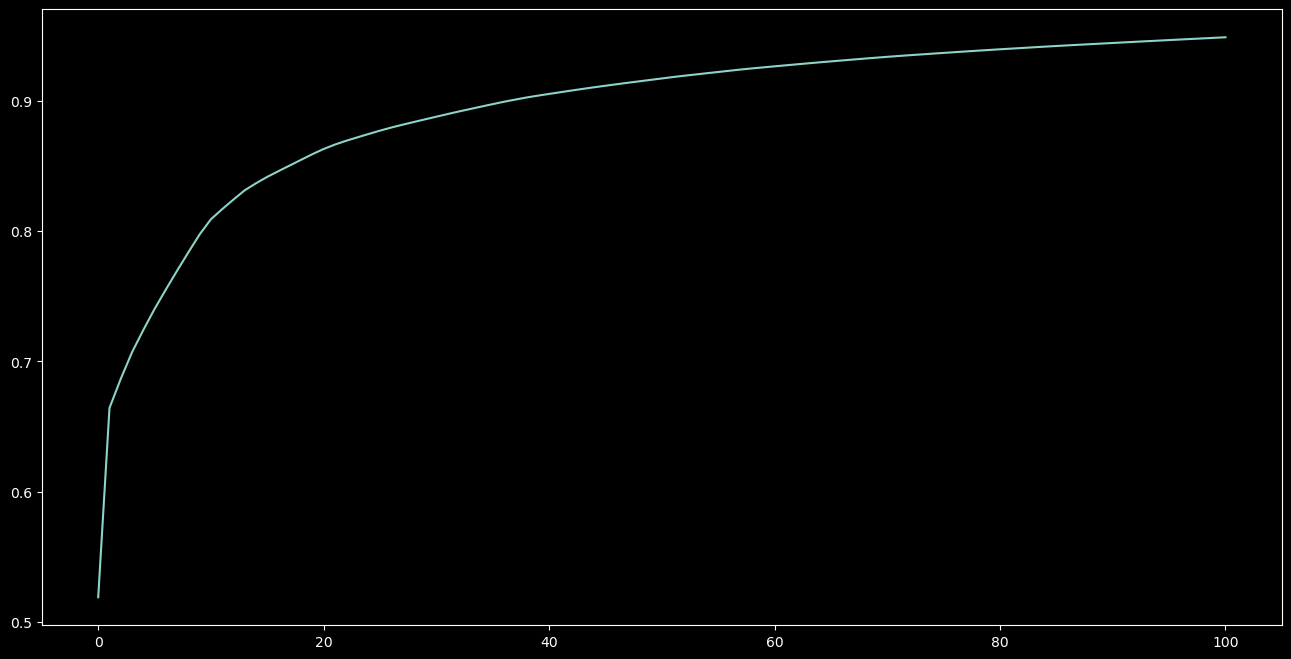

In [22]:
reg.importance_type = 'total_gain'
cumul_importance_thresh = 0.9

df_fi = pd.DataFrame({'feat': cols_feat_keep_low_corr, 'imp': reg.feature_importances_})
df_fi = df_fi.sort_values('imp', ascending=False).reset_index(drop=True)
df_fi['imp_c'] = df_fi.imp.cumsum()
important_features = df_fi.loc[df_fi.imp_c <= cumul_importance_thresh, 'feat']

print(df_fi.shape)
print(len(important_features), 'features contribute {}% of cumulative importance'.format(100.*cumul_importance_thresh))
df_fi.to_csv(data_path.joinpath("analytics_demo").joinpath('df_fi.csv'), index=None)
display(df_fi.head(20))
# df_fi.loc[df_fi.feat.isin(important_features), 'imp_c'].plot.line()
df_fi.loc[:100, 'imp_c'].plot.line(figsize=(16, 8))

I suppose it makes sense that asset size is the best proxy for company size. However I've never seen a single feature be assigned half the total importance. And just a half dozen features hold 75% of the predictive value!

It's also surprising to see share-based compensation, as a fraction of assets (`sbcomp_over_assetsavg_art`), make an appearance in the top features. Does that perhaps indicate growth companies, which tend to have higher valuation multiples?

Let's glance at prediction error.

,err,frac_err
count,820732.000,820732.000
mean,0.597,0.076
std,0.597,0.323
min,0.000,0.000
25%,0.195,0.017
50%,0.433,0.039
75%,0.810,0.076
max,9.565,13.799


array([[<Axes: title={'center': 'err'}>,
        <Axes: title={'center': 'frac_err'}>]], dtype=object)

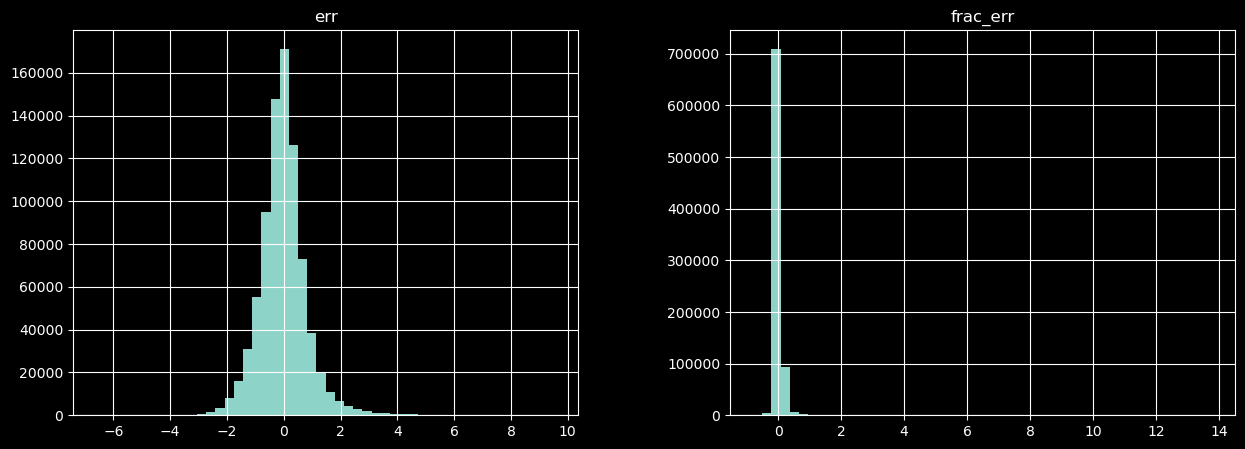

In [21]:
df_score['err'] = df_score.pred - df_score.mcap_daily_scaled_log
df_score['frac_err'] = (df_score.pred - df_score.mcap_daily_scaled_log) / df_score.mcap_daily_scaled_log
display(df_score[['err', 'frac_err']].abs().describe())
df_score[['err', 'frac_err']].hist(bins=50, figsize=(15, 5))

Absolute percent error is more interesting to me since it's independent of company scale. We see a mean absolute percent error (known as MAPE) of `7.6%` and a median of `4%`, meaning half the predictions were within 4% of true company value. Not bad!

Looks percent error (not absolute) is unsteady through time:

<Axes: xlabel='date'>

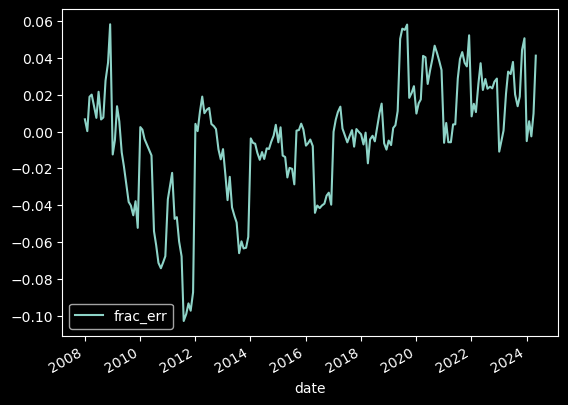

In [22]:
df_score[['date', 'frac_err']].groupby('date').median().sort_index().plot()

Now, notice that a positive `frac_error` means that the stock looks undervalued to XGboost. If we've done an adequate job, the higher this number goes, the better the bargain we're likely to find.

So let's find out if that's true. I'll use `excess_price_chg_1y`, which measures a stock's price change minus the market's return. So a value of `-0.2` means it trailed the market by 20% over the following year, and `0.5` means it beat the market by 50% in that period. If you'd like to see how `excess_price_chg_1y` is computed, have a look at in the dbt sub-project's `models` folder.

In [24]:
df_score = df_score.merge(df_fct_daily_targ[['key_daily', 'excess_price_chg_1y']], how='inner', on='key_daily')
df_score.head(10)

,key_daily,date,mcap_daily_scaled_log,pred,err,frac_err,excess_price_chg_1y
0,LORL_2012-06-05,2012-06-05,12.757,12.285,-0.472,-0.037,0.251
1,SIX_2016-08-03,2016-08-03,13.701,12.666,-1.035,-0.076,0.002
2,IDSA_2012-08-03,2012-08-03,8.516,8.434,-0.081,-0.010,-0.360
3,GNMK_2019-08-05,2019-08-05,10.394,12.321,1.928,0.185,0.338
4,MOBQ_2011-10-05,2011-10-05,8.746,7.371,-1.375,-0.157,-0.522
5,GSIH_2009-12-03,2009-12-03,10.954,9.990,-0.964,-0.088,-0.272
6,PFBX_2016-04-05,2016-04-05,8.967,8.588,-0.378,-0.042,0.261
7,PGI_2015-06-03,2015-06-03,11.072,11.408,0.336,0.030,0.289
8,REN_2017-10-04,2017-10-04,11.324,11.225,-0.100,-0.009,0.022
9,IMNPQ_2012-01-05,2012-01-05,7.336,8.537,1.201,0.164,-0.491


Let's check base performance first.

In [25]:
# Subset to rows with 1-year return values (so they're at least a year old)
df_score_epc = df_score[~df_score.excess_price_chg_1y.isnull()].copy()

# Performance of all stocks
print('All securities, stockwise performance:')
display(df_score_epc.excess_price_chg_1y.agg(['count', 'mean', 'median']))
print('\nAll securities, daily performance:')
display(df_score_epc[['date', 'excess_price_chg_1y']].groupby('date').mean().agg(['count', 'mean', 'median']).excess_price_chg_1y)

All securities, stockwise performance:


count    768285.000
mean          0.012
median       -0.030
Name: excess_price_chg_1y, dtype: float64


All securities, daily performance:


count    184.000
mean       0.012
median    -0.013
Name: excess_price_chg_1y, dtype: float64

Now we'll look at performance for the top couple percent of `frac_err`.

In [31]:
# Performance of top 2%
sel_most_undervalued = df_score_epc.frac_err > df_score_epc.frac_err.quantile(.98)
print('Top 2%, stockwise performance:')
display(df_score_epc.loc[sel_most_undervalued, 'excess_price_chg_1y'].agg(['count', 'mean', 'median']))
print('\nTop 2%, daily performance:')
display(df_score_epc.loc[sel_most_undervalued, ['date', 'excess_price_chg_1y']].groupby('date').mean().agg(['count', 'mean', 'median']).excess_price_chg_1y)

Top 2%, stockwise performance:


count    15366.000
mean         0.370
median      -0.197
Name: excess_price_chg_1y, dtype: float64


Top 2%, daily performance:


count    184.000
mean       0.322
median     0.054
Name: excess_price_chg_1y, dtype: float64

37% stock-wise outperformance -- pretty cool, but it's cherry-picking the top 2% from 2008 to present, after the fact.

Instead, what if I'd picked the 20 most-undervalued stocks each day? Since I predicted forward in time, this is actually valid methodology:

In [48]:
# Daily rank of prediction error, most positive is rank #1
df_score_epc['daily_rnk'] = df_score_epc[['date', 'frac_err']].groupby('date').rank(ascending=False, method='first')
sel_most_undervalued_daily = df_score_epc.daily_rnk <= 20

print('Top 20 daily, stockwise performance:')
display(df_score_epc.loc[sel_most_undervalued_daily, 'excess_price_chg_1y'].agg(['count', 'mean', 'median']))
print('\nTop 20 daily, daily performance:')
display(df_score_epc.loc[sel_most_undervalued_daily, ['date', 'excess_price_chg_1y']].groupby('date').mean().agg(['count', 'mean', 'median']).excess_price_chg_1y)

Top 20 daily, stockwise performance:


count    3680.000
mean        0.612
median     -0.112
Name: excess_price_chg_1y, dtype: float64


Top 20 daily, daily performance:


count    184.000
mean       0.612
median     0.158
Name: excess_price_chg_1y, dtype: float64

Beating the market by 61.2%? Hmm... it's almost... too good to be true. I'll say more about that in the conclusion. :)

What's that ride like day-to-day?

count   184.000
mean      0.612
std       2.182
min      -0.484
25%      -0.062
50%       0.158
75%       0.624
max      24.472
Name: excess_price_chg_1y, dtype: float64

<Axes: xlabel='date'>

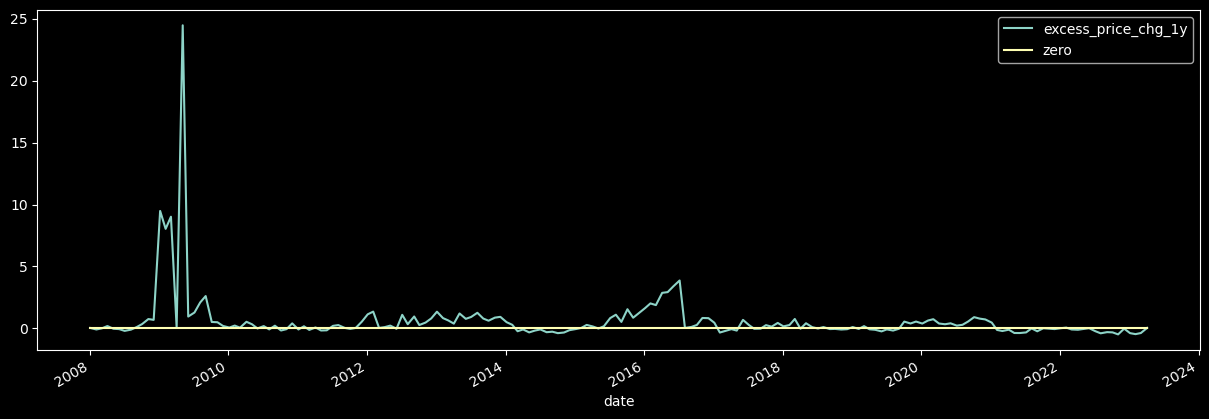

In [49]:
df_daily_perf = df_score_epc.loc[sel_most_undervalued_daily, ['date', 'excess_price_chg_1y']].groupby('date').mean()
df_daily_perf['zero'] = 0
display(df_daily_perf.excess_price_chg_1y.describe())
df_daily_perf.plot.line(figsize=(15, 5))

It's hard to tell due to the peaks, such as the GFC and the COVID crash. Let's truncate those stellar days to get a better look.

<Axes: xlabel='date'>

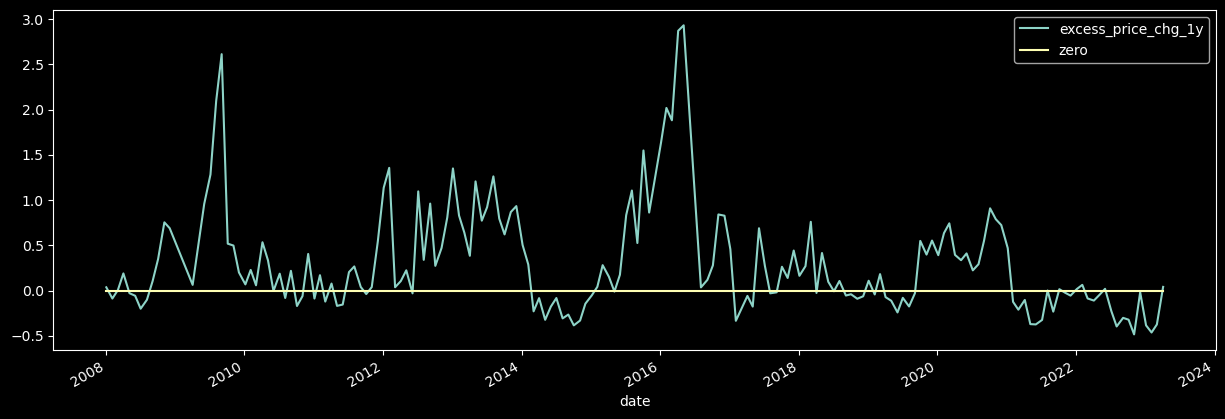

In [50]:
df_daily_perf[df_daily_perf.excess_price_chg_1y < 3].plot.line(figsize=(15, 5))

Doesn't look too bad, but it also doesn't look like a fun ride for long stretches of time. Would there have been signs of upcoming underperformance? What I mean is, could this system have shown me when there weren't many deals about?

We'll compute the daily median `frac_err` again, but this time only for the top 20 stocks, then we'll plot it through time. We're looking for large positive values as a sign of abundant cheap stocks, and drops as a sign that there aren't many bargains.

<Axes: xlabel='date'>

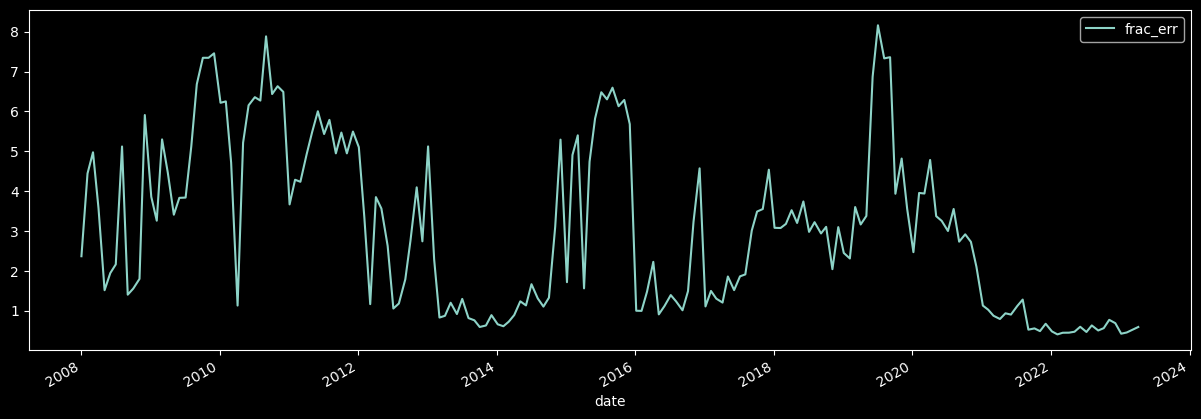

In [51]:
df_score_epc.loc[sel_most_undervalued_daily, ['date', 'frac_err']].groupby('date').median().plot.line(figsize=(15, 5))

Certainly the lower performance lately corresponds to lower median `frac_err`, but that doesn't appear universally true. Let's look at a scatter plot between the two.

,excess_price_chg_1y,daily_median_frac_err
excess_price_chg_1y,1.000,0.060
daily_median_frac_err,0.060,1.000


<Axes: xlabel='daily_median_frac_err', ylabel='excess_price_chg_1y'>

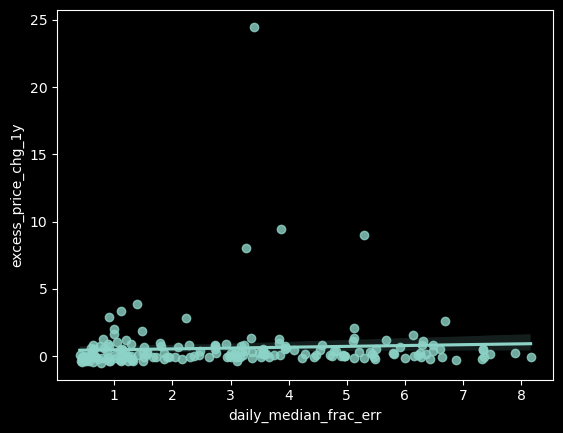

In [52]:
import seaborn as sns

df_daily_med_frac_error = df_score_epc.loc[sel_most_undervalued_daily, ['date', 'frac_err']].groupby('date').median()
df_daily_scatter = df_daily_perf.merge(df_daily_med_frac_error, how='inner', left_index=True, right_index=True)
df_daily_scatter = df_daily_scatter.rename(columns={'frac_err': 'daily_median_frac_err'})

display(df_daily_scatter.drop(columns='zero').corr())
sns.regplot(data=df_daily_scatter, x='daily_median_frac_err', y='excess_price_chg_1y')

Zooming in on the majority once again by removing the top performers:

,excess_price_chg_1y,daily_median_frac_err
excess_price_chg_1y,1.000,0.047
daily_median_frac_err,0.047,1.000


<Axes: xlabel='daily_median_frac_err', ylabel='excess_price_chg_1y'>

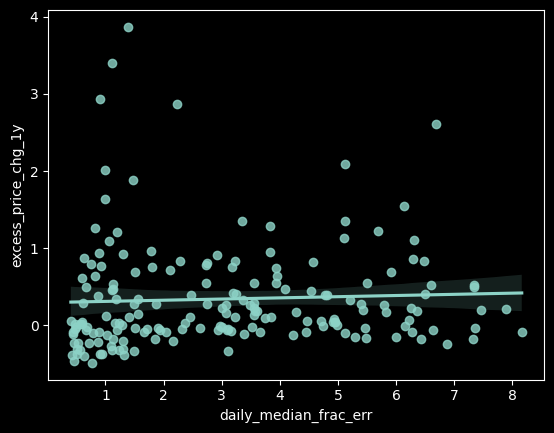

In [53]:
sel_remove_outliers = df_daily_scatter.excess_price_chg_1y < 4
display(df_daily_scatter[sel_remove_outliers].drop(columns='zero').corr())
sns.regplot(data=df_daily_scatter[sel_remove_outliers], x='daily_median_frac_err', y='excess_price_chg_1y')

Yeah, no strong relationship evident there. In other words, it probably wouldn't make sense to wait for days with tons of cheap-looking stocks. Anyway, probably only happens during a big crash, precisely when an instrument like this isn't needed to infer that stocks are cheap.

# Conclusion

That's a lot of progress in one notebook! However, the preceding is far, far from anything you'd want to use to inform investing decisions. Here's a list of unsolved sub-problems in no particular order.

- Dataset
    - Testing
        - missing
        - conformity to expectations
    - Filter unwanted instances
        - International stocks
        - Meme stocks/penny stocks
    - Ensure liquidity
        - Is it actually traded?
        - Market cap floor
- Modeling / problem framing
    - Need better features
        - Typically, one should study which features are working and try to "repeat what works", as Charlie Munger said.
        - Cohort/industry/competition level metrics
        - Lagged target
        - Do a better job capturing trends in financials
        - Capture insider trading & other corporate events
        - Measure "classic factors" directly: dividends, quality, momentum, value
    - Try other models
    - Try model averaging and/or stacking
    - Consider targeteting market outperformance directly, rather than mcap
    - Handle market system changes
        - e.g., credit cycle: firm debt sensitivity is higher now than in much of this dataset
    - Unsupervised ML as preprocessing: See if there are clusters which, if you model each separately, improve predictions.
    - Should you quantify uncertainty? That is, use statistics more clasically?
- Understanding performance
    - Weighting by estimated (under-) valuation rather than equal weighting.
    - Optimal purchase strategy -- buy every day or wait for good deals?
    - Optimal number of stocks to buy
    - Multi-period scoring: how long to hold?
    - Exit strategy
    - Taxation considerations
    - Compounding performance -- Is there a risk of ruin?
    - Industry/sector diversification
    - Systematic error analysis: Find and understand any *error trends*; try to engineer features or acquire data to address them.